<a href="https://colab.research.google.com/github/emmayeh-0211/2021AI_ml/blob/main/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
from urllib.request import urlretrieve
url = "https://raw.githubusercontent.com/emmayeh-0211/2021AI_ml/main/train.csv"
urlretrieve(url, "train.csv")
url = "https://raw.githubusercontent.com/emmayeh-0211/2021AI_ml/main/test.csv"
urlretrieve(url, "test.csv")

('test.csv', <http.client.HTTPMessage at 0x7fbbd3d21190>)

In [84]:
import pandas as pd
train_df = pd.read_csv("train.csv", encoding="utf-8")
test_df = pd.read_csv("test.csv", encoding="utf-8")

In [85]:
# 把訓練跟驗證的資料先合併，準備進行資料的前處理
# 不需要資料處理的欄位先drop掉
data = pd.concat([train_df, test_df], ignore_index=True)
data = data.drop(["PassengerId", "Survived"], axis=1)

In [86]:
# 資料處理第一步 處理空值
# 把有空值的欄位篩選出來，進行資料前處理
na = data.isna().sum() #.isna() 尋找空值 .sum() 計算總數
# Series[帶入跟該列資料筆數一樣多的True/False list，來篩選要留下來的資料]
na[na > 0].sort_values(ascending=False) # .sort_values() 排列

Cabin       1014
Age          263
Embarked       2
Fare           1
dtype: int64

In [87]:
# 資料前處理
# 先處理Cabin
def cabin_head(s):
  if not pd.isna(s):
    return s[0]

data['Cabin'] = data['Cabin'].apply(cabin_head)

In [88]:
# Tickets 這邊要根據持有的票號，去算同一行人有多少人，然後把該數值放入tickets的資料內，意思是我們不看票號資訊，而是要新增一個資料是根據票號去算同行人數
# 因此先用 .value_counts() 去算各票號的次數（代表多少人持有同一個票號）
# 再將 data中 ticket的資訊替換成同一行人的數字（其實要取代或新增資料應該都是可以的）
dic = data['Ticket'].value_counts()
data['Ticket'] = data['Ticket'].apply(lambda t:dic[t])

In [89]:
# 補缺失值(類別 -> 最常出現) [!，如果後續還有測試資料需要做資料前處理, 空值的部分不能重算, 直接補原本data中該欄位補的空值，不能大家各自補不同的空值]
most = data["Embarked"].value_counts().idxmax()
data["Embarked"] = data["Embarked"].fillna(most) # .fillna() 將空值補上括號()的值
na = data.isna().sum()
na[na > 0].sort_values(ascending=False)

Cabin    1014
Age       263
Fare        1
dtype: int64

In [90]:
# 補缺失值（數值：中位數）
# .median() 查看各欄位的中位數
# 其中 Pclass艙等不是數值，是類別，因此將它從資料中drop掉
med = data.median().drop(['Pclass'])
data = data.fillna(med)  # 這裡為什麼不用指定空值要補在哪一欄裡？
na = data.isna().sum()
# Series[帶入跟該列資料筆數一樣多的True/False list，來篩選要留下來的資料]
na[na > 0].sort_values(ascending=False)

Cabin    1014
dtype: int64

In [91]:
# 資料前處理，將名字的部分，只保留稱謂類型
def name_convert(name):
  name = name.split(',')[-1].split('.')[0]
  name = name.strip()
  return name
counts = data['Name'].apply(name_convert).value_counts()
whiltelist = counts[counts > 50].index
def name_convert(name):
  name = name.split(',')[-1].split('.')[0]
  name = name.strip()
  if name in whiltelist:
    return name
  else:
    return None
data['Name'] = data['Name'].apply(name_convert)

In [92]:
# Step 2，進行one hot encoding
# 用.get_dummies()，就會自動偵測資料中字串中，就進行one hot encoding
data = pd.get_dummies(data) 
# 一開始Pclass 被偵測為數值，所以沒有被one hot encoding
# Pclass雖然是類別，但是是具大小關係的的類別項目，所以可以不做one hot encoding
# 但是根據老師之前做完的結果，發現這個欄位還是要做one hot encoding準確度會比較高
# 因此這邊使用 get_dummies(data, columns=[要放一個列表]) 的方式，data針對Pclass這個欄位進行one hot encoding
data = pd.get_dummies(data, columns=['Pclass'])
data

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,38.0,1,0,2,71.2833,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
2,26.0,0,0,1,7.9250,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
3,35.0,1,0,2,53.1000,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
4,35.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1305,39.0,0,0,3,108.9000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
1306,38.5,0,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1307,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1


In [93]:
# 因為同行直系血親跟旁系血親其實就等於家庭成員的數量，因此新增一個把他們相加後增加一個Family member的欄位
# 但這件事其實是模型建立完後，
data['Family'] = data['SibSp'] + data['Parch']
data

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
0,22.0,1,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
1,38.0,1,0,2,71.2833,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1
2,26.0,0,0,1,7.9250,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,35.0,1,0,2,53.1000,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1
4,35.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1305,39.0,0,0,3,108.9000,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
1306,38.5,0,0,1,7.2500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
1307,28.0,0,0,1,8.0500,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [94]:
# .iloc (根據第幾個來選擇，不是根據編號)
# 用法 .iloc[第一列，第二列，第三列...]
x_train = data.iloc[:train_df.shape[0]]
y_train = train_df['Survived']
x_predict = data.iloc[train_df.shape[0]:]

In [95]:
import numpy as np
from sklearn.model_selection import cross_val_score # 交叉驗證
from sklearn.model_selection import GridSearchCV # 這什麼？
# 隨機森林可以放入不同參數來去調整模型，透過GridSearchCV可以將各種可能的參數放進去來找出最好的分數跟參數
# GridSearchCV會跑非常久，將近10min！
from sklearn.ensemble import RandomForestClassifier # 隨機森林
params = {
    "n_estimators":range(20, 100),
    "max_depth":range(3, 11)
}
clf = RandomForestClassifier()
cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
cv.fit(x_train, y_train)
print(cv.best_score_)
print(cv.best_params_)

.RandomForestClassifier有幾個參數可以設定
(n_estimators=100, max_depth=None)

這次用到的有兩個
n_estimators：隨機森林中，要用幾顆決策樹
max_depth：決策樹的深度

In [96]:
# 得到GridSearchCV找出來最佳參數後，可以再手動測試參數的微調，去看看得出來的分數會不會有變化、何者參數較好
# 先做隨機森林，再做交叉驗證（cross validation)
clf = RandomForestClassifier(n_estimators=33, max_depth=7)
scores = cross_val_score(clf, x_train, y_train, cv=10, n_jobs=-1)
print("10:", scores)
print("average:", np.average(scores))

10: [0.83333333 0.85393258 0.73033708 0.87640449 0.87640449 0.82022472
 0.84269663 0.79775281 0.86516854 0.82022472]
average: 0.8316479400749064


In [105]:
clf = RandomForestClassifier(n_estimators=33, max_depth=8)
clf.fit(x_train, y_train)
pre = clf.predict(x_predict)
df = pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":pre
})
df.to_csv("rf.csv", encoding="utf-8", index=False)
df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


[Text(279.0, 475.65000000000003, 'Family <= 0.5\ngini = 0.462\nsamples = 567\nvalue = [568, 323]\nclass = Dead'),
 Text(139.5, 339.75, 'Sex_female <= 0.5\ngini = 0.404\nsamples = 342\nvalue = [388, 152]\nclass = Dead'),
 Text(69.75, 203.85000000000002, 'Embarked_Q <= 0.5\ngini = 0.224\nsamples = 263\nvalue = [360, 53]\nclass = Dead'),
 Text(34.875, 67.94999999999999, '\n  (...)  \n'),
 Text(104.625, 67.94999999999999, '\n  (...)  \n'),
 Text(209.25, 203.85000000000002, 'Embarked_S <= 0.5\ngini = 0.344\nsamples = 79\nvalue = [28, 99]\nclass = Alived'),
 Text(174.375, 67.94999999999999, '\n  (...)  \n'),
 Text(244.125, 67.94999999999999, '\n  (...)  \n'),
 Text(418.5, 339.75, 'Ticket <= 4.5\ngini = 0.5\nsamples = 225\nvalue = [180, 171]\nclass = Dead'),
 Text(348.75, 203.85000000000002, 'Name_Mr <= 0.5\ngini = 0.491\nsamples = 183\nvalue = [124, 163]\nclass = Alived'),
 Text(313.875, 67.94999999999999, '\n  (...)  \n'),
 Text(383.625, 67.94999999999999, '\n  (...)  \n'),
 Text(488.25, 20

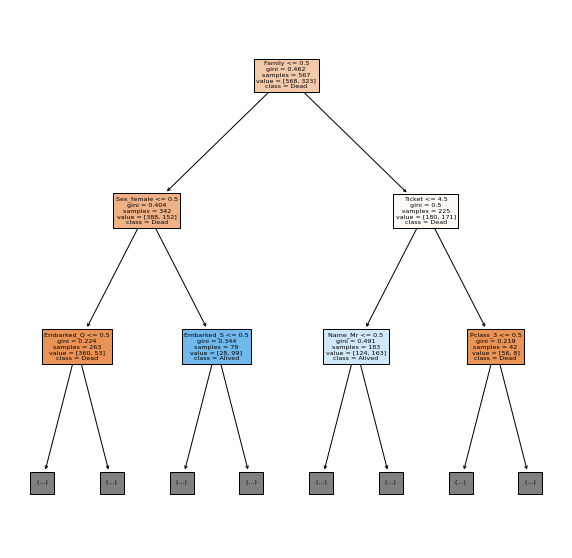

In [106]:
# 抓出隨機森林中的決策樹，來畫出決策樹，了解其決策順序
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(10, 10))
plot_tree(clf.estimators_[2], 
          feature_names=data.columns, 
          class_names=["Dead", "Alived"],
          max_depth=2,
          filled=True)

In [108]:
# 隨機森林可以.feature_importances_的方式，了解不同因素在決策樹中的重要性程度，所有因素加起來會等於1
pd.DataFrame({
    "Name":data.columns,
    "Importance":clf.feature_importances_
}).sort_values(by="Importance", ascending=False)

,Name,Importance
9,Sex_female,0.158628
7,Name_Mr,0.140454
10,Sex_male,0.120101
4,Fare,0.117409
0,Age,0.083098
3,Ticket,0.069533
24,Pclass_3,0.047896
25,Family,0.038392
1,SibSp,0.032178
22,Pclass_1,0.030324


In [101]:
from sklearn.preprocessing import MinMaxScaler #因為等一下要用距離的演算法KNN，所以要在這邊先對資料作前處理，將資料中的數字都做scaling
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data)
data_scale = pd.DataFrame(data_scale, columns=data.columns)
# .loc (根據列編號)(X) .iloc (根據第幾個)(O)
# .iloc [第一列, 第二列, 第三列...]
x_train_scale = data_scale.iloc[:train_df.shape[0]]
x_predict_scale = data_scale.iloc[train_df.shape[0]:]
x_train_scale

,Age,SibSp,Parch,Ticket,Fare,Name_Master,Name_Miss,Name_Mr,Name_Mrs,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Family
0,0.273456,0.125,0.000000,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.1
1,0.473882,0.125,0.000000,0.1,0.139136,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.1
2,0.323563,0.000,0.000000,0.0,0.015469,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0.436302,0.125,0.000000,0.1,0.103644,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.1
4,0.436302,0.000,0.000000,0.0,0.015713,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.336089,0.000,0.000000,0.0,0.025374,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
887,0.235876,0.000,0.000000,0.0,0.058556,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
888,0.348616,0.125,0.222222,0.3,0.045771,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.3
889,0.323563,0.000,0.000000,0.0,0.058556,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


.KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None, **kwargs) 可以設定的參數有數個

KNN演算法是透過找跟預測資料 附近的點去判斷是哪種分類
n_neighbors 就是設定總共要找幾個點來參考

In [100]:
from sklearn.neighbors import KNeighborsClassifier # 載入KNN演算法
params = {
    "n_neighbors":range(3, 100)
}
clf = KNeighborsClassifier()
cv = GridSearchCV(clf, params, cv=10, n_jobs=-1)
cv.fit(x_train_scale, y_train)
print(cv.best_score_)
print(cv.best_params_)

0.832796504369538
{'n_neighbors': 7}


In [102]:
# 把測試的預測的結果存成csv檔
clf = KNeighborsClassifier(n_neighbors=11)
clf.fit(x_train_scale, y_train)
pre = clf.predict(x_predict_scale)
df = pd.DataFrame({
    "PassengerId":test_df["PassengerId"],
    "Survived":pre
})
df.to_csv("knn.csv", encoding="utf-8", index=False)
df

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
